In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
cirs = np.load('cirs_noised_ld.npy')
cirs_obs = np.load('cirs_observation_ld.npy')
triplets = np.load('triplets_ld.npy')
anchor_idx = np.load('anchor_idx.npy')
pos_idx = np.load('pos_idx.npy')
neg_idx = np.load('neg_idx.npy')

In [4]:
# miu, sigma = cirs.mean(), cirs.var()

# cirs = (cirs - cirs.min()) / (cirs.max() - cirs.min())
# cirs_obs = (cirs_obs - cirs_obs.min()) / (cirs_obs.max() - cirs_obs.min())

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [7]:
def normalize_complex_arr(a):
    a_oo = a - a.real.min() - 1j*a.imag.min() # origin offsetted
    return a_oo/np.abs(a_oo).max()

In [8]:
cirs_real, cirs_img = np.real(cirs), np.imag(cirs)
cirs_obs_real, cirs_obs_img = np.real(cirs_obs), np.imag(cirs_obs)

In [9]:
cirs_complex = np.stack([cirs_real, cirs_img], axis=-1) * 10
cirs_obs_complex = np.stack([cirs_obs_real, cirs_obs_img], axis=-1) * 10

In [9]:
np.mean(cirs_obs), np.mean(cirs)

((9.225493438332279e-08-1.1522068276486939e-08j),
 (1.0528227549875248e-07+2.2889703369286082e-08j))

In [10]:
P = np.array([cirs_obs[trp[0]] for trp in triplets])
Pi = np.array([cirs[trp[1]] for trp in triplets])
Pj = np.array([cirs[trp[2]] for trp in triplets])

In [11]:
def loss_hinge(p, pi, pj, W, margin=1):
    return max(0, margin - p.T @ W @ pi + p.T @ W @ pj)

def loss_global(triplets, W, cirs, cirs_obs):
    return np.sum([loss_hinge(cirs_obs[i0], cirs[i1], cirs[i2], W) for i0, i1, i2 in triplets])

def gradient(W, P, Pi, Pj):
    grad = np.zeros_like(W)

def gradient_descent():
    ...

## Triplet loss with Keras

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, Flatten, Input, Dense, LayerNormalization, Dropout, Concatenate, LeakyReLU
from tensorflow.keras.layers import Lambda, Dot
from tensorflow.keras.regularizers import l2
from keras.callbacks import History 
from keras import backend as K

In [14]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras import layers


def identity_loss(y_true, y_pred):
    """Ignore y_true and return the mean of y_pred
    
    This is a hack to work-around the design of the Keras API that is
    not really suited to train networks with a triplet loss by default.
    """
    return tf.reduce_mean(y_pred)


class MarginLoss(layers.Layer):

    def __init__(self, margin=1):
        super().__init__()
        self.margin = margin
        
    def call(self, inputs):
        pos_pair_similarity = inputs[0]
        neg_pair_similarity = inputs[1]
        
        # diff = (neg_pair_similarity - pos_pair_similarity) * 2 / (pos_pair_similarity + neg_pair_similarity)
        diff = pos_pair_similarity - neg_pair_similarity
        return tf.maximum(diff + self.margin, 0.)
    

def average_roc_auc(model, triplets_train, triplets_test):
    """Compute the ROC AUC for each user and average over users"""
    max_user_id = max(data_train['user_id'].max(),
                      data_test['user_id'].max())
    max_item_id = max(data_train['item_id'].max(),
                      data_test['item_id'].max())
    user_auc_scores = []
    for user_id in range(1, max_user_id + 1):
        pos_item_train = triplets_train[1]
        pos_item_test = triplets_test[1]
        
        # Consider all the items already seen in the training set
        all_item_ids = np.arange(1, max_item_id + 1)
        items_to_rank = np.setdiff1d(
            all_item_ids, pos_item_train['item_id'].values)
        
        # Ground truth: return 1 for each item positively present in
        # the test set and 0 otherwise.
        expected = np.in1d(
            items_to_rank, pos_item_test['item_id'].values)
        
        if np.sum(expected) >= 1:
            # At least one positive test value to rank
            repeated_user_id = np.empty_like(items_to_rank)
            repeated_user_id.fill(user_id)

            predicted = model.predict(
                [repeated_user_id, items_to_rank], batch_size=4096)
        
            user_auc_scores.append(roc_auc_score(expected, predicted))

    return sum(user_auc_scores) / len(user_auc_scores)

In [15]:
def sample_triplets(triplets, cir_obs, cir_base, random_seed=0):
    obs, pos_comp, neg_comp = [], [], []
    rng = np.random.RandomState(random_seed)
    for i, j, _ in triplets:
        obs.append(cir_obs[i])
        pos_comp.append(cir_base[j])

    neg_comp = cir_base[rng.randint(low=0, high=len(cirs), size=len(triplets))]

    return [np.array(obs), np.array(pos_comp), np.array(neg_comp)]

In [16]:
def sample_triplets_onetoten(anchor, pos, neg, cir_obs, cir_base, random_seed=0):
    obs, pos_comp, neg_comp = [], [], []
    rng = np.random.RandomState(random_seed)
    label = []
    sample_data = []
    # for i in anchor:
    #     for j, ks in zip(pos, neg):
    for i, js, ks in zip(anchor, pos, neg):
        for j, k in zip(js, ks):
            k_sample10 = rng.choice(ks, 10)
            # sample_data.append([cir_obs[i], cir_base[j], cir_base[k]])
            for k in k_sample10:
                obs.append(cir_obs[i])
                pos_comp.append(cir_base[j])
                neg_comp.append(cir_base[k])
                label.append(i)

    return [label, obs, pos_comp, neg_comp]

In [17]:
anchor, pos, neg = sample_triplets(triplets, cirs_obs_complex, cirs_complex)

In [18]:
label, anchor, pos, neg = sample_triplets_onetoten(anchor_idx, pos_idx, neg_idx, cirs_obs_complex, cirs_complex)

In [40]:
anchor_idx.shape, pos_idx.shape, neg_idx.shape

((400,), (400, 10), (400, 389))

10248

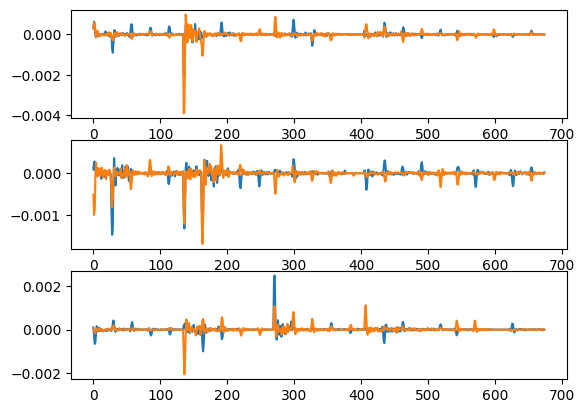

In [18]:
ind = np.random.randint(len(anchor))

fig, axs = plt.subplots(3,1)
axs[0].plot(anchor[ind])
axs[1].plot(pos[ind])
axs[2].plot(neg[ind])
ind

In [19]:
class ComplexDense(layers.Layer):
    def __init__(self, n_input, activation='relu'):
        super().__init__()
        self.complex_real = Dense(n_input, activation=activation)
        self.complex_imag = Dense(n_input, activation=activation)

    def call(self, input):
        input_real = tf.math.real(input)
        input_img = tf.math.imag(input)
        return self.complex_real(input_real) - self.complex_imag(input_img) + 1j * (self.complex_real(input_img) + self.complex_imag(input_real))

class TripletModel(Model):
    def __init__(self, n_observation, n_comparison, margin=1., latent_dim=64, l2_reg=None):
        super().__init__(name="TripletModel")
        
        self.margin = margin
        
        l2_reg = None if l2_reg == 0 else l2(l2_reg)
        # self.obs_layer = Embedding(n_observation, n_observation,
        #                             name='obs_embedding',
        #                             embeddings_regularizer=l2_reg)
        # self.comp_layer = Embedding(n_comparison, n_comparison,
        #                     name='comp_embedding',
        #                     embeddings_regularizer=l2_reg)
        self.normalization = LayerNormalization()

        self.dot = Dot(axes=1, normalize=True)

        self.margin_loss = MarginLoss(margin)

        self.dense_1 = Dense(n_observation)
        self.dense_2 = Dense(n_comparison)

        self.lrelu = LeakyReLU(alpha=.05)

        self.n_obs = n_observation
        self.n_comp = n_comparison
        
    def call(self, inputs, training=False):
        obs_input, pos_input, neg_input = inputs[0], inputs[1], inputs[2]

        # self.normalization.adapt(obs_input)
        # obs_nmlz = self.normalization(obs_input)
        # pos_nmlz = self.normalization(pos_input)
        # neg_nmlz = self.normalization(neg_input)
        # a = obs.nmlz.real

        # latent feature
        obs = self.dense_1(obs_input)
        pos = self.dense_2(pos_input) 
        neg = self.dense_2(neg_input) 

        obs = self.lrelu(obs)
        pos = self.lrelu(pos)
        neg = self.lrelu(neg)

        # obs /= tf.norm(obs)
        # pos /= tf.norm(pos)
        # neg /= tf.norm(neg)
        
        # Similarity computation between embeddings
        pos_similarity = self.dot([obs, pos])
        neg_similarity = self.dot([obs, neg])
                
        return self.margin_loss([pos_similarity, neg_similarity])
    
    def model(self):
        x = Input(shape=(self.n_obs))
        y = Input(shape=(self.n_comp))
        z = Input(shape=(self.n_comp))
        return Model(inputs=[x, y, z], outputs=self.call(x))

In [20]:
class ComplexTriplet(Model):
    def __init__(self, n_observation, n_comparison, margin=1., latent_dim=64, l2_reg=None):
        super().__init__(name="ComplexTripletModel")
        
        self.margin = margin
        
        l2_reg = None if l2_reg == 0 else l2(l2_reg)
        # self.obs_layer = Embedding(n_observation, n_observation,
        #                             name='obs_embedding',
        #                             embeddings_regularizer=l2_reg)
        # self.comp_layer = Embedding(n_comparison, n_comparison,
        #                     name='comp_embedding',
        #                     embeddings_regularizer=l2_reg)
        # self.normalization = LayerNormalization()

        self.dot = Dot(axes=1, normalize=True)

        self.margin_loss = MarginLoss(margin)

        self.flatten = Flatten()

        self.dense_1 = Dense(n_observation)
        self.dense_2 = Dense(n_comparison)

        self.lrelu = LeakyReLU(alpha=.05)

        self.n_obs = n_observation
        self.n_comp = n_comparison
        
    def call(self, inputs, training=False):
        obs_input, pos_input, neg_input = inputs[0], inputs[1], inputs[2]

        obs_nmlz = self.flatten(obs_input)
        pos_nmlz = self.flatten(pos_input)
        neg_nmlz = self.flatten(neg_input)
        # latent feature
        obs = self.dense_1(obs_nmlz)
        pos = self.dense_2(pos_nmlz) 
        neg = self.dense_2(neg_nmlz) 

        obs = self.lrelu(obs)
        pos = self.lrelu(pos)
        neg = self.lrelu(neg)

        # obs /= tf.norm(obs)
        # pos /= tf.norm(pos)
        # neg /= tf.norm(neg)
        
        # Similarity computation between embeddings
        pos_similarity = self.dot([obs, pos]) * self.n_obs * self.n_comp
        neg_similarity = self.dot([obs, neg]) * self.n_obs * self.n_comp
                
        return self.margin_loss([pos_similarity, neg_similarity])
    
    def model(self):
        x = Input(shape=(self.n_obs, 2))
        y = Input(shape=(self.n_comp, 2))
        z = Input(shape=(self.n_comp, 2))
        return Model(inputs=[x, y, z], outputs=self.call([x, y, z]))

In [63]:
anchor_test[0].shape, cirs_obs_complex.shape
for i in range(400):
    if (anchor_test[0] == cirs_obs_complex[i]).all():
        print(i)

303


In [21]:
class DistanceModel(Model):
    def __init__(self, TModel):
        super().__init__(name="distance_measure")

        self.dot = Dot(axes=1, normalize=True)

        self.flatten = Flatten()

        self.dense_1 = TModel.dense_1
        self.dense_2 = TModel.dense_2

        
    def predict(self, inputs):
        obs_input, comp_input = inputs[0], inputs[1]

        # self.normalization.adapt(obs_input)
        obs_flatten = self.flatten(obs_input)
        comp_flatten = self.flatten(comp_input)
        # latent feature
        obs = self.dense_1(obs_flatten)
        comp = self.dense_2(comp_flatten)
        
        return self.dot([obs, comp])
    
    def model(self):
        x = Input(shape=(675, 2))
        y = Input(shape=(675, 2))
        # z = Input(shape=(self.n_comp, 2))
        return Model(inputs=[x, y], outputs=self.call([x, y]))

In [22]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5221504024812685516
xla_global_id: -1
]


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
data_train, data_val, label_train, label_val = train_test_split(np.stack([anchor, pos, neg], -1), label, train_size=.75, random_state=0)
data_train, data_test, label_train_2, label_test = train_test_split(data_train, label_train, train_size=.9, random_state=0)

In [25]:
anchor_train, anchor_test, anchor_val = data_train[:, :, :, 0], data_test[:, :, :, 0], data_val[:, :, :, 0]
pos_train, pos_test, pos_val = data_train[:, :, :, 1], data_test[:, :, :, 1], data_val[:, :, :, 1]
neg_train, neg_test, neg_val = data_train[:, :, :, 2], data_test[:, :, :, 2], data_val[:, :, :, 2]

In [30]:
from tensorflow.keras.optimizers import SGD
sgd = SGD(learning_rate=.05, decay=.1/10, nesterov=False)

In [ ]:
history = History()

fake_y = np.ones(len(anchor_train))

dim_obs = cirs_obs.shape[1]
dim_comp = cirs.shape[1]

triplet_model = None
triplet_model = ComplexTriplet(dim_obs, dim_comp, l2_reg=1e-6, margin=2)

triplet_model.compile(loss=identity_loss, optimizer=sgd)

n_epochs = 5
batch_size = 64

# for i in range(n_epochs):
#     # Sample new negatives to build different triplets at each epoch
#     # triplet_inputs = sample_triplets(triplets, cirs_obs_complex, cirs_complex, random_seed=i)
#     # triplet_model.fit(x=triplet_inputs, y=np.ones(len(cirs)), shuffle=True,
#     #                   batch_size=32, epochs=1, callbacks=[history])

#     # Fit the model incrementally by doing a single pass over the
#     # sampled triplets.
sampled_inputs = [anchor_train, pos_train, neg_train]
validation_inputs = [anchor_test, pos_test, neg_test]
validation_y_fake = np.ones(len(anchor_test))

triplet_model.fit(x=sampled_inputs, y=fake_y, shuffle=True,
                    batch_size=32, epochs=20, callbacks=[history], validation_data=[validation_inputs, validation_y_fake])

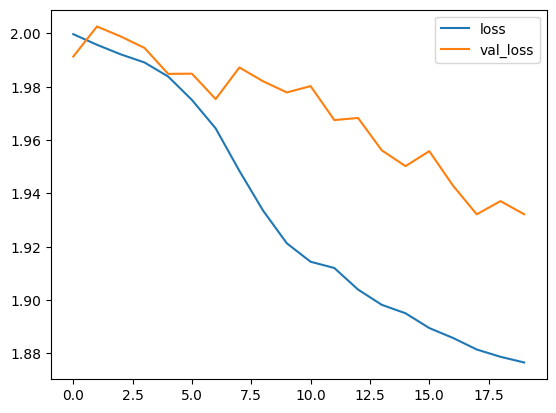

In [418]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

In [419]:
out = triplet_model.predict([anchor_test, pos_test, neg_test])
out2 = triplet_model.predict([anchor_test, neg_test, pos_test])

94/94 [==============================] - 1s 7ms/step


In [422]:
ss = []
dm = DistanceModel(triplet_model)
for c in cirs_obs_complex:
    score_tmp = dm.predict(np.expand_dims([anchor_test[0], c], axis=1))
    ss.append(score_tmp.numpy()[0][0])

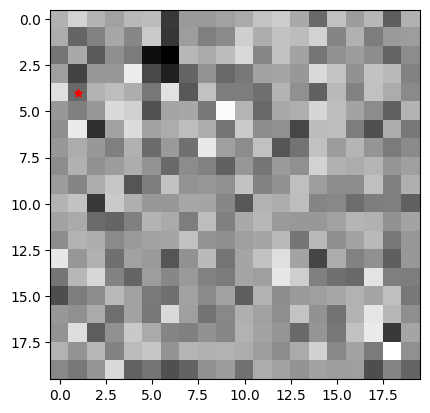

In [480]:
ss = []
ind = np.random.randint(len(anchor_test))
dm = DistanceModel(triplet_model)
for c in cirs_obs_complex:
    score_tmp = dm.predict(np.expand_dims([anchor_test[ind], c], axis=1))
    ss.append(score_tmp.numpy()[0][0])

img = np.reshape(ss, (20, 20))
i, j = label_test[ind]//20, label_test[ind]%20
plt.scatter(i, j, c='red', marker='*')
plt.imshow(img, cmap='gray')


In [67]:
ind = np.random.choice(len(triplet_inputs[0]))
anchor_test, pos_test, neg_test = triplet_inputs[0][ind], triplet_inputs[1][ind], triplet_inputs[2][ind]

## Deep triplet model

In [32]:
class MLP(layers.Layer):
    def __init__(self, n_hidden=1, hidden_size=64, dropout=0.,
                 l2_reg=None):
        super().__init__()

        # self.layers = [Dropout(dropout)]
        self.layers=[]

        for _ in range(n_hidden):
            self.layers.append(Dense(hidden_size, activation="relu",
                                     kernel_regularizer=l2_reg))
            # self.layers.append(Dropout(dropout))

        self.layers.append(Dense(1, activation="sigmoid",
                                 kernel_regularizer=l2_reg))
            # self.layers.append(Dense(1, kernel_regularizer=l2_reg, activation='sigmoid'))
            # self.layers.append(LeakyReLU(alpha=.05))

    def call(self, x, training=False):
        for layer in self.layers:
            # if isinstance(layer, Dropout):
            #     x = layer(x, training=training)
            # else:
                x = layer(x)
        return x
    

class DeepTripletModel(Model):
    def __init__(self, n_users, n_items, user_dim=32, item_dim=64, margin=1.,
                 n_hidden=1, hidden_size=64, dropout=0, l2_reg=None):
        super().__init__()

        l2_reg = None if l2_reg == 0 else l2(l2_reg)

        self.flatten = Flatten()
        self.concat = Concatenate(axis=0)
        # self.dense = Dense(1, activation='sigmoid')
        self.mlp = MLP(n_hidden, hidden_size, dropout, l2_reg)

        self.margin_loss = MarginLoss(margin)

    def call(self, inputs):
        obs = inputs[0]
        pos = inputs[1]
        neg = inputs[2]

        # Similarity computation between embeddings
        pos_embeddings_pair = self.concat([obs, pos])
        neg_embeddings_pair = self.concat([obs, neg])

        pos_embeddings_pair /= tf.norm(pos_embeddings_pair)
        neg_embeddings_pair /= tf.norm(neg_embeddings_pair)

        pos_embeddings_pair = self.flatten(pos_embeddings_pair)
        neg_embeddings_pair = self.flatten(neg_embeddings_pair)

        pos_similarity = self.mlp(pos_embeddings_pair)
        neg_similarity = self.mlp(neg_embeddings_pair)

        # pos_similarity = self.dense(pos_similarity)
        # neg_similarity = self.dense(neg_similarity)

        return self.margin_loss([pos_similarity, neg_similarity])
    
    def model(self):
        x = Input(shape=(675, 2))
        y = Input(shape=(675, 2))
        z = Input(shape=(675, 2))
        return Model(inputs=[x, y, z], outputs=self.call([x, y, z]))

In [33]:
class DeepDistanceModel(Model):
    def __init__(self, DTModel):
        super().__init__(name="deep_distance_measure")
        
        self.flatten = Flatten()
        self.concat = DTModel.concat
        self.mlp = DTModel.mlp
        # self.dense = DTModel.dense
        
    def predict(self, inputs):
        obs, comp = inputs[0], inputs[1]
        x = self.concat([obs, comp])
        x /= tf.norm(x)
        x = self.flatten(x)
        x = self.mlp(x)         
        # out = self.dense(x)      
        return x
    
    def model(self):
        x = Input(shape=(675, 2))
        # z = Input(shape=(self.n_comp, 2))
        return Model(inputs=x, outputs=self.predict(x))

In [45]:
hyper_parameters = dict(
    n_hidden=2,
    hidden_size=64,
    dropout=0.1,
    l2_reg=0.,
)

deep_triplet_model_2 = DeepTripletModel(dim_obs, dim_comp, margin=2,
                                      **hyper_parameters)

deep_triplet_model_2.compile(loss=identity_loss, optimizer='adam')
deep_triplet_model_2.fit(x=sampled_inputs, y=fake_y, shuffle=True,
                    batch_size=32, epochs=1)

844/844 [==============================] - 2s 2ms/step - loss: 1.9906


In [54]:
np.shape(sampled_inputs)

(3, 27000, 675, 2)

In [53]:
deep_triplet_model_2.predict(sampled_inputs)

844/844 [==============================] - 1s 2ms/step


array([[1.9898376],
       [2.00293  ],
       [2.002648 ],
       ...,
       [1.222149 ],
       [1.4575161],
       [2.8858242]], dtype=float32)

In [57]:
from tensorflow.keras.optimizers import SGD
sgd = SGD(learning_rate=.1, decay=.1/n_epochs, nesterov=False)


In [ ]:
hyper_parameters = dict(
    n_hidden=2,
    hidden_size=64,
    dropout=0.1,
    l2_reg=0.,
)
deep_triplet_model = DeepTripletModel(dim_obs, dim_comp, margin=2,
                                      **hyper_parameters)

deep_triplet_model.compile(loss=identity_loss, optimizer=sgd)
# fake_y = np.ones_like(pos_data_train['user_id'])

deep_history = History()
triplet_inputs = [anchor_train, pos_train, neg_train]
validation_inputs = [anchor_test, pos_test, neg_test]
validation_y_fake = np.ones(len(anchor_test))
deep_triplet_model.fit(x=triplet_inputs, y=fake_y, shuffle=True,
                    batch_size=32, epochs=20, callbacks=[deep_history], validation_data=[validation_inputs, validation_y_fake])

In [ ]:
hyper_parameters = dict(
    n_hidden=2,
    hidden_size=64,
    dropout=0.1,
    l2_reg=0.,
)
deep_triplet_model = DeepTripletModel(dim_obs, dim_comp, margin=2,
                                      **hyper_parameters)

deep_triplet_model.compile(loss=identity_loss, optimizer=sgd)
# fake_y = np.ones_like(pos_data_train['user_id'])
n_epochs = 10
deep_history = History()

for i in range(n_epochs):
    if i == 1:
        triplet_inputs = [anchor_train, pos_train, neg_train]
    else:
        deep_triplet_model
    # validation_inputs = [anchor_test, pos_test, neg_test]
    # validation_y_fake = np.ones(len(anchor_test))
    deep_triplet_model.fit(x=triplet_inputs, y=fake_y, shuffle=True,
                        batch_size=32, epochs=20, callbacks=[deep_history]])

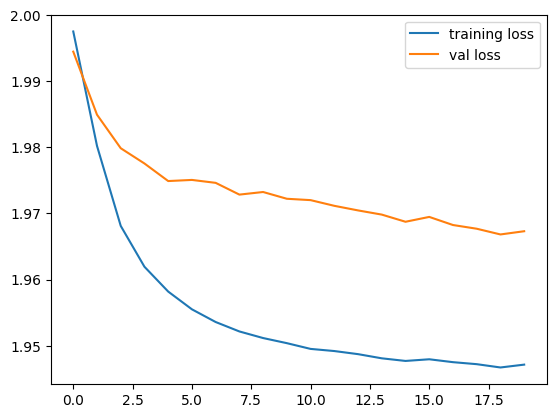

In [521]:
plt.plot(deep_history.history['loss'])
plt.plot(deep_history.history['val_loss'])
plt.legend(['training loss', 'val loss'])

In [467]:
ss = []
dm = DeepDistanceModel(deep_triplet_model)
for c in cirs_obs_complex:
    score_tmp = dm.predict(np.expand_dims([anchor_test[0], c], axis=1))
    ss.append(score_tmp.numpy()[0][0])

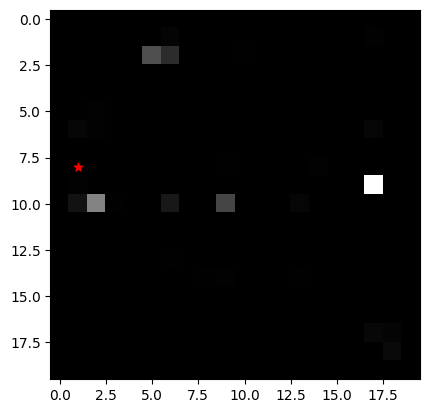

In [539]:
ss = []
ind = np.random.randint(len(anchor_test))
# dm = DistanceModel(triplet_model)
dm = DeepDistanceModel(deep_triplet_model)
for c in cirs_obs_complex:
    score_tmp = dm.predict(np.expand_dims([anchor_test[ind], c], axis=1))
    ss.append(score_tmp.numpy()[0][0])

img = np.reshape(ss, (20, 20))
i, j = label_test[ind]//20, label_test[ind]%20
plt.scatter(j, i, c='red', marker='*')
plt.imshow(img, cmap='gray')

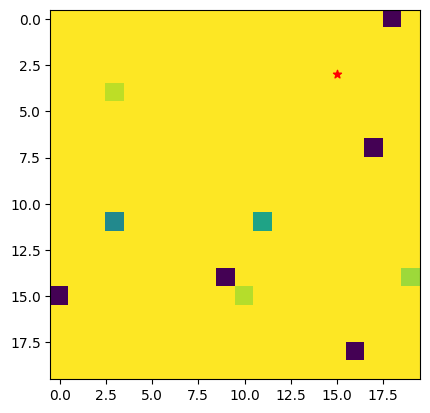

In [469]:
img2 = np.reshape(ss, (20, 20))
i, j = label_test[0]//20, label_test[0]%20

plt.scatter(i, j, c='red', marker='*')
plt.imshow(img2)

In [81]:
for i in range(10):
    # Sample new negatives to build different triplets at each epoch
    # triplet_inputs = sample_triplets(triplets, cirs_obs, cirs, random_seed=i)

    # # Fit the model incrementally by doing a single pass over the
    # # sampled triplets.
    # deep_triplet_model.fit(x=triplet_inputs, y=fake_y, shuffle=True,
    #                   batch_size=32, epochs=1, callbacks=[deep_history])
    triplet_inputs = [anchor_train, pos_train, neg_train]
    validation_inputs = [anchor_test, pos_test, neg_test]
    validation_y_fake = np.ones(len(anchor_test))
    deep_triplet_model.fit(x=triplet_inputs, y=fake_y, shuffle=True,
                      batch_size=32, epochs=1, callbacks=[deep_history], validation_data=[validation_inputs, validation_y_fake])

938/938 [==============================] - 19s 20ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00


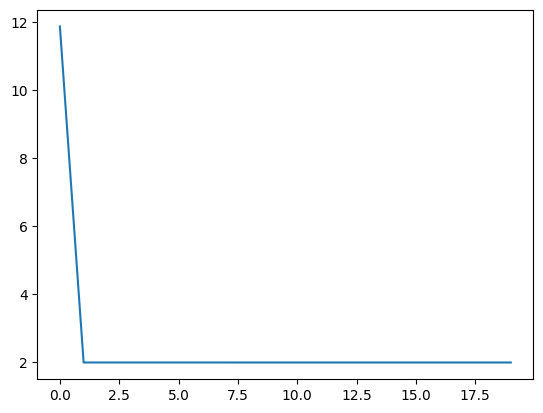